In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy.io import fits
from astropy.visualization import simple_norm

import ccdproc as ccdp

Filename: ../reduced_lights/pp_r01.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (3840, 2160)   float64   
  1  MASK          1 ImageHDU         8   (3840, 2160)   uint8   
  2  UNCERT        1 ImageHDU         9   (3840, 2160)   float64   


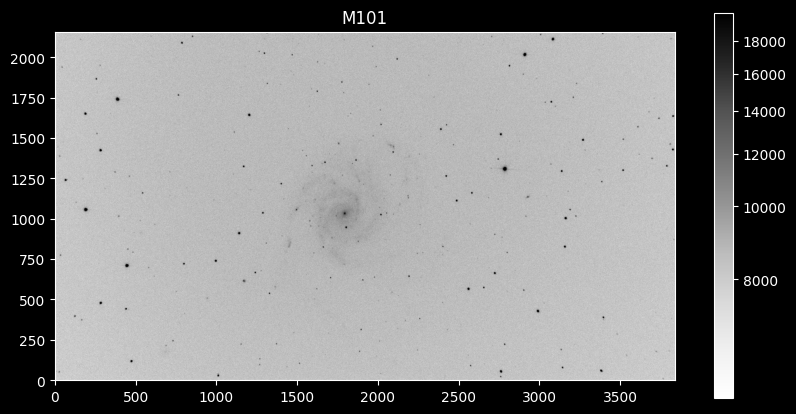

In [13]:
file_name = '../reduced_lights/pp_r01.fit'

hdul = fits.open(file_name)
hdul.info()

image_data = hdul[0].data * 65536
header = hdul[0].header
hdul.close()

norm = simple_norm(image_data, stretch='sqrt', percent=99.9)
plt.style.use('dark_background')
plt.figure(figsize=(10, 5))
plt.imshow(image_data, cmap='Greys', norm=norm, origin='lower')
plt.colorbar()
plt.title('M101')
plt.show()

In [115]:
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3840                                                  
NAXIS2  =                 2160                                                  
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
INSTRUME= 'ZWO ASI585MC'       / instrument name                                
DATE    = '2025-07-15T23:30:04' / UTC date that FITS file was created           
DATE-OBS= '2024-10-23T16:27:01' / YYYY-MM-DDThh:mm:ss observation start, UT     
EXPTIME =                 180. / Exposure time [s]                              
XPIXSZ  =                  2

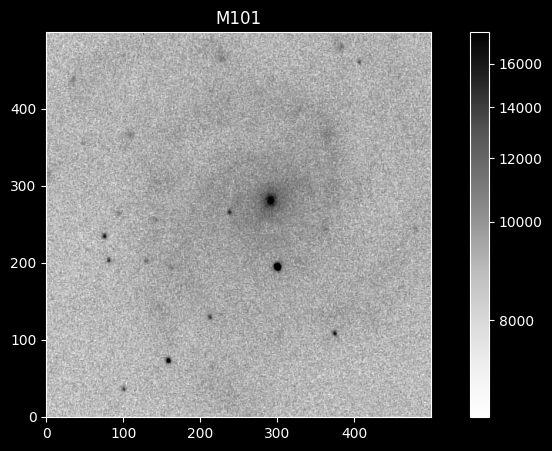

In [104]:
section1 = image_data[750:1250, 1500:2000]

norm = simple_norm(section1, stretch='sqrt', percent=99.9)
plt.figure(figsize=(10, 5))
plt.imshow(section1, cmap='Greys', norm=norm, origin='lower')
plt.colorbar()
plt.title('M101')
plt.show()

In [105]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(section1, sigma=3.0)

print(mean, median, std)

9218.31719634187 9195.730160304478 569.1453194570929


In [106]:
from photutils.detection import DAOStarFinder

daofind = DAOStarFinder(fwhm = 3.0, threshold = 5.0*std)

sources = daofind(section1-median)

for col in sources.colnames:
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'

sources.pprint(max_width = 100)

 id xcentroid ycentroid sharpness roundness1 roundness2 npix   peak      flux    mag   daofind_mag
--- --------- --------- --------- ---------- ---------- ---- -------- --------- ------ -----------
  1    100.80     35.43      0.31      -0.15       0.46   25  5081.06  65532.41 -12.04       -0.43
  2    158.98     72.69      0.65      -0.16       0.51   25 22866.57 266642.45 -13.56       -1.56
  3    374.57    107.78      0.49      -0.12       0.57   25  7958.82 117134.29 -12.67       -0.45
  4    213.01    128.90      0.56      -0.06       0.20   25  5964.50  76862.57 -12.21       -0.20
  5    300.67    194.42      0.47      -0.01       0.10   25 59256.24 981783.28 -14.98       -2.26
  6    300.22    196.60      0.43      -0.14       0.62   25 52421.21 875478.34 -14.86       -2.32
  7     81.14    202.77      0.21       0.24       0.22   25  4772.48  74872.98 -12.19       -0.11
  8     75.75    234.21      0.57      -0.01       0.44   25  9997.13 122437.02 -12.72       -0.67
  9    238

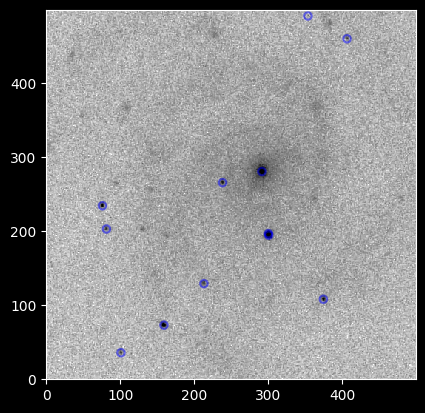

In [109]:
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

apertures = CircularAperture(positions, r = 5.0)

norm = simple_norm(section1, stretch='sqrt', percent=99.9)
plt.imshow(section1, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')

apertures.plot(color = 'blue', lw = 1.5, alpha = 0.5)
plt.show()

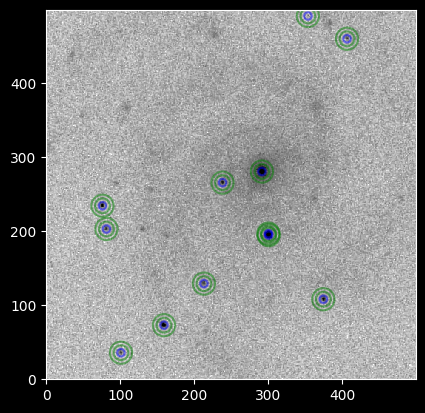

In [110]:
from photutils.aperture import CircularAnnulus, CircularAperture, ApertureStats, aperture_photometry

annulus_aperture = CircularAnnulus(positions, r_in = 10, r_out= 15)

plt.figure()
norm = simple_norm(section1, stretch='sqrt', percent=99.9)
plt.imshow(section1, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
annulus_aperture.plot(color='green', lw=1.5, alpha=0.5)
plt.show()

In [111]:
aperstats = ApertureStats(section1, annulus_aperture)
bkg_mean = aperstats.mean
aperture_area = apertures.area_overlap(section1)
total_bkg = bkg_mean * aperture_area

star_data = aperture_photometry(section1, apertures)

star_data['total_bkg'] = total_bkg

for col in star_data.colnames:
    star_data[col].info.format = '%.8g'

star_data.pprint()

 id  xcenter   ycenter  aperture_sum total_bkg
--- --------- --------- ------------ ---------
  1 100.79582 35.428227    812409.24 691304.51
  2  158.9813 72.691414      1114855 708569.07
  3 374.56592 107.77652    912138.02 727141.95
  4 213.01131 128.89964    863603.97 734943.42
  5 300.66873 194.41895    2686734.4 767188.62
  6  300.2154 196.60436    2557470.5 767399.76
  7  81.13724 202.77046    840379.99 702755.01
  8 75.746203 234.21302    910370.69 701390.49
  9 238.18073 265.51263    922952.75 785684.95
 10 291.45461 280.54945    1424886.9 929628.14
 11 406.60462 460.14671     794959.7 720671.95
 12 353.67276 490.97531    715698.24 716573.76


In [120]:
extime = 180

import math

ZP = 16.2 + 2.5*math.log10(abs(922952.75-785684.95)/extime)

In [122]:
extime = 180

import math
magnitudes = []

for line in star_data:
    magnitudes.append(ZP-(2.5*math.log10(abs(line[3]-line[4])/extime)))

star_data['magnitude'] = magnitudes
star_data.pprint(max_lines = -1, max_width = -1)

 id  xcenter   ycenter  aperture_sum total_bkg     magnitude     
--- --------- --------- ------------ --------- ------------------
  1 100.79582 35.428227    812409.24 691304.51 16.336018902904847
  2  158.9813 72.691414      1114855 708569.07 15.021842308160922
  3 374.56592 107.77652    912138.02 727141.95 15.876015418818355
  4 213.01131 128.89964    863603.97 734943.42 16.270308151935257
  5 300.66873 194.41895    2686734.4 767188.62 13.335925496424217
  6  300.2154 196.60436    2557470.5 767399.76  13.41174621115597
  7  81.13724 202.77046    840379.99 702755.01 16.197178486765758
  8 75.746203 234.21302    910370.69 701390.49 15.743658826447204
  9 238.18073 265.51263    922952.75 785684.95  16.20000001397173
 10 291.45461 280.54945    1424886.9 929628.14 14.806841347352485
 11 406.60462 460.14671     794959.7 720671.95   16.8666286429863
 12 353.67276 490.97531    715698.24 716573.76 21.688251547209102
